In [2]:
import numpy as np

def precision_k_score(val_labels, train_labels, indexes, k):
    k = min(k, indexes.shape[1])

    top_k_indexes = indexes[:, :k]

    pred_labels = train_labels[top_k_indexes]
    matches = pred_labels == val_labels[:, np.newaxis]

    return np.mean(np.any(matches, axis=1))

In [3]:
def recall_k_score(val_labels, train_labels, indexes, k):
    k = min(k, indexes.shape[1])

    top_k_indexes = indexes[:, :k]

    pred_labels = train_labels[top_k_indexes]
    matches = pred_labels == val_labels[:, np.newaxis]

    total_relevant_per_sample = np.array([np.sum(train_labels == label) for label in val_labels])

    relevant_in_top_k = np.sum(matches, axis=1)

    recall_k = np.mean(relevant_in_top_k / total_relevant_per_sample) if total_relevant_per_sample != 0 else 0.0

    return recall_k

In [4]:
def compute_map(val_labels, train_labels, indexes, k):
    ap_scores = []

    k = min(k, indexes.shape[1])

    indexes = indexes[:, :k]

    for query_label, pred_indices in zip(val_labels, indexes):
        relevance = (train_labels[pred_indices] == query_label).astype(int)
        if relevance.sum() == 0:
            ap_scores.append(0.0)
            continue

        cumsum_rel = np.cumsum(relevance)
        precision_at_k = cumsum_rel / np.arange(1, len(pred_indices) + 1)
        ap_scores.append((precision_at_k * relevance).sum() / relevance.sum())

    return np.mean(ap_scores)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import scipy.io
mat = scipy.io.loadmat("/content/drive/MyDrive/Colab Notebooks/devkit/cars_train_annos.mat")
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [7]:
ADD_PATH = '/content/drive/MyDrive/Colab Notebooks/cars_train'

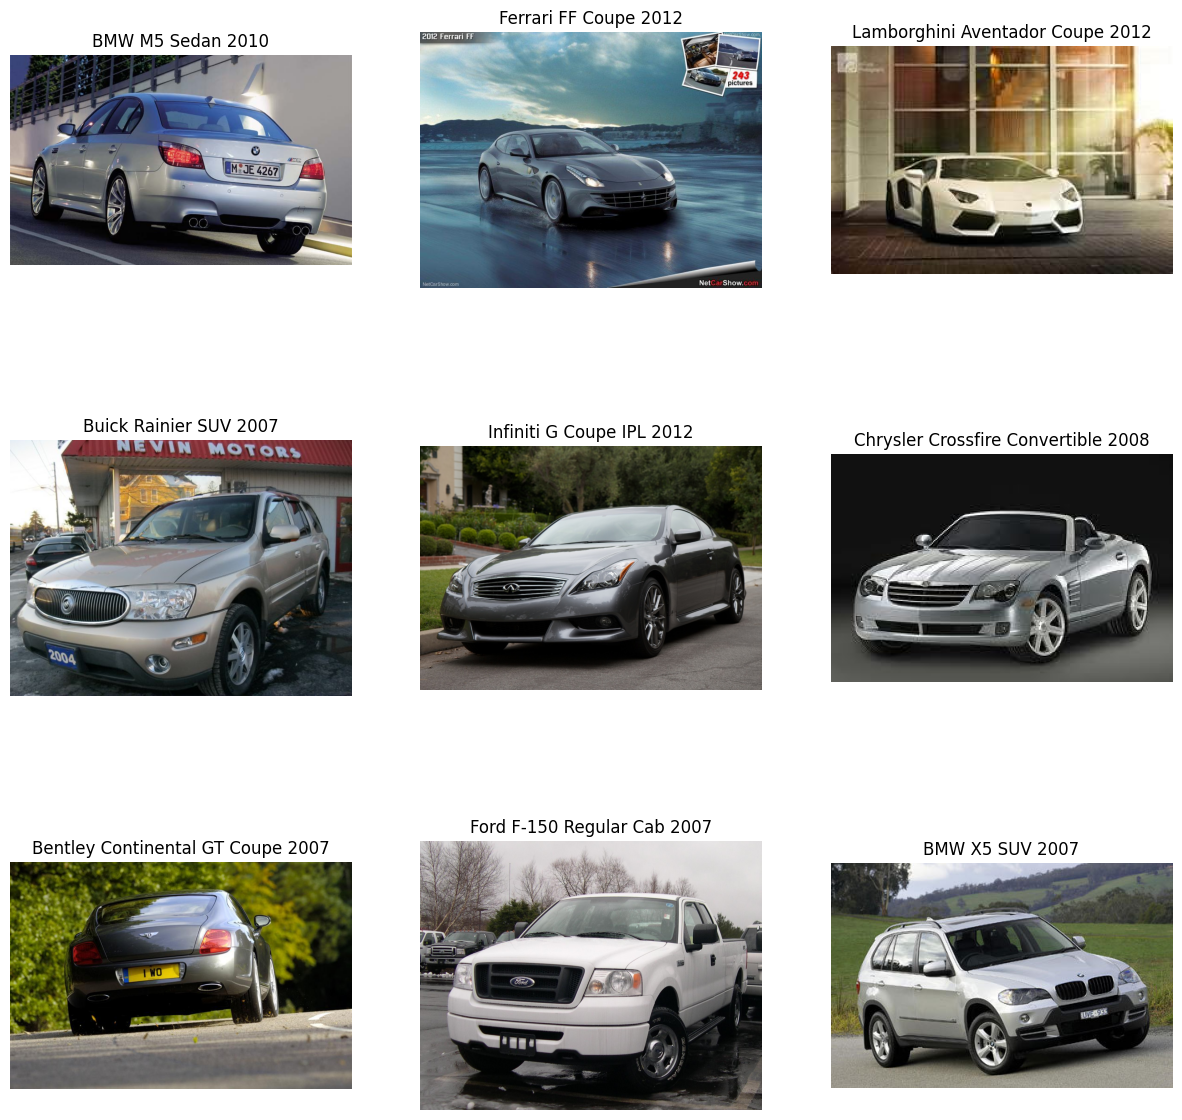

In [8]:
import matplotlib.pyplot as plt
import random
import cv2
import os

num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

In [9]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(degrees=15, fill=(0,), ),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        print(f"Индекс {idx}, значение self.cars[{idx}]: {self.cars[idx]}")
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [10]:
items = list(fname_to_class.items())

random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, train_transform)
val_dataset = CropClassifDataset(val_items, val_transform)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:

!pip install pytorch-metric-learning
!pip install pytorch-lightning
!pip install lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 51.4 MB/s eta 0:00:00


In [13]:
from pytorch_metric_learning import losses, miners
import lightning.pytorch as pl
from torchvision.models import efficientnet_b0

class Embedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size):
        super().__init__()
        self.learning_rate = learning_rate

        self.model = efficientnet_b0(weights='IMAGENET1K_V1')

        self.model.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=2048, out_features=emb_size)
        )

        self.triplet_loss = losses.TripletMarginLoss(margin=0.2)

        self.miner = miners.TripletMarginMiner(
            margin=0.2,
            type_of_triplets="semihard"
        )

        self.save_hyperparameters()

    def training_step(self, batch):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)

        hard_pairs = self.miner(preds, labels)

        loss = self.triplet_loss(preds, labels, hard_pairs)

        self.log("train_loss", loss, sync_dist=True)
        return loss

    def validation_step(self, batch):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)

        hard_pairs = self.miner(preds, labels)

        loss = self.triplet_loss(preds, labels, hard_pairs)

        self.log("validation_loss", loss, sync_dist=True)

    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images)
        else:
            preds = self.model(images.unsqueeze(0))
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return [optimizer]



In [14]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
device = 'cuda'

pl_model = Embedder(id_to_car, 0.0005, 512)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval="step")
pl_model.to(device)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator=device,
    devices=1,
    callbacks=[early_stopping, lr_monitor]
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 114MB/s] 
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | EfficientNet       | 6.3 M  | train
1 | triplet_loss | TripletMarginLoss  | 0      | train
2 | miner        | TripletMarginMiner | 0      | train
------------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.351    Total estimated model params size (MB)
344       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | model        | EfficientNet       | 6.3 M  | train
1 | triplet_loss | TripletMarginLoss  | 0      | train
2 | miner        | TripletMarginMiner | 0      | trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Индекс 32, значение self.cars[32]: (np.str_('05851.jpg'), np.uint8(94))Индекс 0, значение self.cars[0]: (np.str_('06013.jpg'), np.uint8(194))Индекс 16, значение self.cars[16]: (np.str_('04949.jpg'), np.uint8(16))


Индекс 48, значение self.cars[48]: (np.str_('01064.jpg'), np.uint8(36))
Индекс 49, значение self.cars[49]: (np.str_('07115.jpg'), np.uint8(21))
Индекс 33, значение self.cars[33]: (np.str_('00188.jpg'), np.uint8(92))
Индекс 1, значение self.cars[1]: (np.str_('07559.jpg'), np.uint8(96))
Индекс 17, значение self.cars[17]: (np.str_('05085.jpg'), np.uint8(22))
Индекс 50, значение self.cars[50]: (np.str_('07220.jpg'), np.uint8(163))
Индекс 2, значение self.cars[2]: (np.str_('03550.jpg'), np.uint8(86))
Индекс 34, значение self.cars[34]: (np.str_('07333.jpg'), np.uint8(170))Индекс 18, значение self.cars[18]: (np.str_('00948.jpg'), np.uint8(79))

Индекс 51, значение self.cars[51]: (np.str_('00095.jpg'), np.uint8(121))
Индекс 19, значение self.cars[19]: (np.str_('05011.jpg'), np.uint8

Training: |          | 0/? [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Индекс 7, значение self.cars[7]: (np.str_('00146.jpg'), np.uint8(41))
Индекс 4596, значение self.cars[4596]: (np.str_('06453.jpg'), np.uint8(9))
Индекс 5838, значение self.cars[5838]: (np.str_('02872.jpg'), np.uint8(147))
Индекс 5602, значение self.cars[5602]: (np.str_('05487.jpg'), np.uint8(116))
Индекс 4471, значение self.cars[4471]: (np.str_('06119.jpg'), np.uint8(84))
Индекс 6218, значение self.cars[6218]: (np.str_('07410.jpg'), np.uint8(187))
Индекс 2508, значение self.cars[2508]: (np.str_('01740.jpg'), np.uint8(154))
Индекс 1938, значение self.cars[1938]: (np.str_('00598.jpg'), np.uint8(27))
Индекс 2240, значение self.cars[2240]: (np.str_('02797.jpg'), np.uint8(11))
Индекс 1265, значение self.cars[1265]: (np.str_('00514.jpg'), np.uint8(108))
Индекс 5325, значение self.cars[5325]: (np.str_('00988.jpg'), np.uint8(22))
Индекс 4474, значение self.cars[4474]: (np.str_('07997.jpg'), np.uint8(141))
Индекс 4685, значение

Validation: |          | 0/? [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Индекс 826, значение self.cars[826]: (np.str_('06099.jpg'), np.uint8(3))
Индекс 5644, значение self.cars[5644]: (np.str_('02766.jpg'), np.uint8(13))
Индекс 519, значение self.cars[519]: (np.str_('00036.jpg'), np.uint8(103))
Индекс 770, значение self.cars[770]: (np.str_('00952.jpg'), np.uint8(194))
Индекс 3396, значение self.cars[3396]: (np.str_('04219.jpg'), np.uint8(165))
Индекс 2886, значение self.cars[2886]: (np.str_('04936.jpg'), np.uint8(71))Индекс 984, значение self.cars[984]: (np.str_('00140.jpg'), np.uint8(190))

Индекс 2987, значение self.cars[2987]: (np.str_('05694.jpg'), np.uint8(8))
Индекс 272, значение self.cars[272]: (np.str_('05268.jpg'), np.uint8(22))Индекс 6394, значение self.cars[6394]: (np.str_('02221.jpg'), np.uint8(31))

Индекс 3713, значение self.cars[3713]: (np.str_('02187.jpg'), np.uint8(142))
Индекс 827, значение self.cars[827]: (np.str_('07379.jpg'), np.uint8(65))
Индекс 27, значение self.cars

Validation: |          | 0/? [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Индекс 5316, значение self.cars[5316]: (np.str_('04263.jpg'), np.uint8(191))
Индекс 1583, значение self.cars[1583]: (np.str_('05665.jpg'), np.uint8(81))
Индекс 5707, значение self.cars[5707]: (np.str_('03501.jpg'), np.uint8(127))
Индекс 125, значение self.cars[125]: (np.str_('00882.jpg'), np.uint8(181))
Индекс 2172, значение self.cars[2172]: (np.str_('02926.jpg'), np.uint8(124))Индекс 92, значение self.cars[92]: (np.str_('01952.jpg'), np.uint8(0))

Индекс 6125, значение self.cars[6125]: (np.str_('07798.jpg'), np.uint8(160))
Индекс 750, значение self.cars[750]: (np.str_('06204.jpg'), np.uint8(31))
Индекс 729, значение self.cars[729]: (np.str_('03533.jpg'), np.uint8(16))
Индекс 1124, значение self.cars[1124]: (np.str_('05916.jpg'), np.uint8(5))
Индекс 2735, значение self.cars[2735]: (np.str_('03292.jpg'), np.uint8(131))
Индекс 5969, значение self.cars[5969]: (np.str_('01759.jpg'), np.uint8(180))Индекс 6111, значение self

Validation: |          | 0/? [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Индекс 5346, значение self.cars[5346]: (np.str_('04430.jpg'), np.uint8(101))
Индекс 2450, значение self.cars[2450]: (np.str_('03283.jpg'), np.uint8(14))
Индекс 6014, значение self.cars[6014]: (np.str_('05369.jpg'), np.uint8(112))
Индекс 3593, значение self.cars[3593]: (np.str_('00875.jpg'), np.uint8(95))
Индекс 2642, значение self.cars[2642]: (np.str_('03378.jpg'), np.uint8(108))
Индекс 3543, значение self.cars[3543]: (np.str_('05980.jpg'), np.uint8(116))Индекс 5434, значение self.cars[5434]: (np.str_('00776.jpg'), np.uint8(118))

Индекс 1217, значение self.cars[1217]: (np.str_('01681.jpg'), np.uint8(32))
Индекс 2237, значение self.cars[2237]: (np.str_('02375.jpg'), np.uint8(109))
Индекс 625, значение self.cars[625]: (np.str_('05323.jpg'), np.uint8(116))
Индекс 3342, значение self.cars[3342]: (np.str_('00245.jpg'), np.uint8(60))
Индекс 2551, значение self.cars[2551]: (np.str_('03940.jpg'), np.uint8(164))
Индекс 2418, з

Validation: |          | 0/? [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Индекс 99, значение self.cars[99]: (np.str_('06789.jpg'), np.uint8(142))
Индекс 6036, значение self.cars[6036]: (np.str_('05089.jpg'), np.uint8(178))
Индекс 5518, значение self.cars[5518]: (np.str_('05823.jpg'), np.uint8(158))Индекс 2134, значение self.cars[2134]: (np.str_('06312.jpg'), np.uint8(94))

Индекс 732, значение self.cars[732]: (np.str_('04597.jpg'), np.uint8(105))
Индекс 5730, значение self.cars[5730]: (np.str_('07951.jpg'), np.uint8(48))
Индекс 2537, значение self.cars[2537]: (np.str_('06782.jpg'), np.uint8(7))
Индекс 5672, значение self.cars[5672]: (np.str_('04701.jpg'), np.uint8(97))
Индекс 3122, значение self.cars[3122]: (np.str_('00823.jpg'), np.uint8(61))
Индекс 1468, значение self.cars[1468]: (np.str_('06839.jpg'), np.uint8(1))
Индекс 5490, значение self.cars[5490]: (np.str_('07654.jpg'), np.uint8(102))
Индекс 2404, значение self.cars[2404]: (np.str_('07730.jpg'), np.uint8(119))
Индекс 6258, значение 

Validation: |          | 0/? [00:00<?, ?it/s]

Индекс 18, значение self.cars[18]: (np.str_('00948.jpg'), np.uint8(79))
Индекс 34, значение self.cars[34]: (np.str_('07333.jpg'), np.uint8(170))
Индекс 2, значение self.cars[2]: (np.str_('03550.jpg'), np.uint8(86))
Индекс 51, значение self.cars[51]: (np.str_('00095.jpg'), np.uint8(121))
Индекс 19, значение self.cars[19]: (np.str_('05011.jpg'), np.uint8(33))
Индекс 35, значение self.cars[35]: (np.str_('02072.jpg'), np.uint8(144))Индекс 20, значение self.cars[20]: (np.str_('02335.jpg'), np.uint8(20))

Индекс 3, значение self.cars[3]: (np.str_('02700.jpg'), np.uint8(120))
Индекс 21, значение self.cars[21]: (np.str_('01668.jpg'), np.uint8(118))
Индекс 4, значение self.cars[4]: (np.str_('00771.jpg'), np.uint8(167))Индекс 52, значение self.cars[52]: (np.str_('03997.jpg'), np.uint8(113))

Индекс 36, значение self.cars[36]: (np.str_('08037.jpg'), np.uint8(70))
Индекс 53, значение self.cars[53]: (np.str_('04727.jpg'), np.uint8(34))
Индекс 22, значение self.cars[22]: (np.str_('03230.jpg'), np.ui

In [26]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Индекс 32, значение self.cars[32]: (np.str_('05851.jpg'), np.uint8(94))
Индекс 16, значение self.cars[16]: (np.str_('04949.jpg'), np.uint8(16))Индекс 0, значение self.cars[0]: (np.str_('06013.jpg'), np.uint8(194))

Индекс 48, значение self.cars[48]: (np.str_('01064.jpg'), np.uint8(36))

Validation: |          | 0/? [00:00<?, ?it/s]


Индекс 33, значение self.cars[33]: (np.str_('00188.jpg'), np.uint8(92))
Индекс 49, значение self.cars[49]: (np.str_('07115.jpg'), np.uint8(21))
Индекс 17, значение self.cars[17]: (np.str_('05085.jpg'), np.uint8(22))
Индекс 1, значение self.cars[1]: (np.str_('07559.jpg'), np.uint8(96))
Индекс 50, значение self.cars[50]: (np.str_('07220.jpg'), np.uint8(163))
Индекс 34, значение self.cars[34]: (np.str_('07333.jpg'), np.uint8(170))
Индекс 18, значение self.cars[18]: (np.str_('00948.jpg'), np.uint8(79))
Индекс 2, значение self.cars[2]: (np.str_('03550.jpg'), np.uint8(86))
Индекс 19, значение self.cars[19]: (np.str_('05011.jpg'), np.uint8(33))
Индекс 35, значение self.cars[35]: (np.str_('02072.jpg'), np.uint8(144))
Индекс 51, значение self.cars[51]: (np.str_('00095.jpg'), np.uint8(121))
Индекс 20, значение self.cars[20]: (np.str_('02335.jpg'), np.uint8(20))
Индекс 3, значение self.cars[3]: (np.str_('02700.jpg'), np.uint8(120))
Индекс 21, значение self.cars[21]: (np.str_('01668.jpg'), np.uin

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │    0.04376273602247238    │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.04376273602247238}]

In [27]:
import tqdm

pl_model.eval()
pl_model.to(device)

Embedder(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activa

In [28]:
def get_embeds(model, loader):
    embeddings = np.empty((1, 1000))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        imgs = batch['image']
        label = batch['label']

        with torch.no_grad():
            preds = model(imgs.to(device))

        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])

    return embeddings[1:].astype(np.float32), labels[1:]

In [38]:
train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

/tmp/ipython-input-384257217.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(loader):


  0%|          | 0/407 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).

Индекс 5614, значение self.cars[5614]: (np.str_('02745.jpg'), np.uint8(143))
Индекс 5187, значение self.cars[5187]: (np.str_('06984.jpg'), np.uint8(14))
Индекс 6500, значение self.cars[6500]: (np.str_('05354.jpg'), np.uint8(171))
Индекс 5124, значение self.cars[5124]: (np.str_('03837.jpg'), np.uint8(88))
Индекс 5069, значение self.cars[5069]: (np.str_('03560.jpg'), np.uint8(41))
Индекс 4251, значение self.cars[4251]: (np.str_('00679.jpg'), np.uint8(100))
Индекс 5172, значение self.cars[5172]: (np.str_('00644.jpg'), np.uint8(108))
Индекс 3818, значение self.cars[3818]: (np.str_('04042.jpg'), np.uint8(92))
Индекс 5942, значение self.cars[5942]: (np.str_('00789.jpg'), np.uint8(161))
Индекс 5558, значение self.cars[5558]: (np.str_('02094.jpg'), np.uint8(145))
Индекс 5355, значение self.cars[5355]: (np.str_('05926.jpg'), np.uint8(155))
Индекс 1270, значение self.cars[1270]: (np.str_('02100.jpg'), np.uint8(88))Индекс 4217, 

  0%|          | 0/102 [00:00<?, ?it/s]

Индекс 16, значение self.cars[16]: (np.str_('04949.jpg'), np.uint8(16))Индекс 32, значение self.cars[32]: (np.str_('05851.jpg'), np.uint8(94))
Индекс 0, значение self.cars[0]: (np.str_('06013.jpg'), np.uint8(194))
Индекс 48, значение self.cars[48]: (np.str_('01064.jpg'), np.uint8(36))

Индекс 1, значение self.cars[1]: (np.str_('07559.jpg'), np.uint8(96))
Индекс 33, значение self.cars[33]: (np.str_('00188.jpg'), np.uint8(92))Индекс 49, значение self.cars[49]: (np.str_('07115.jpg'), np.uint8(21))Индекс 17, значение self.cars[17]: (np.str_('05085.jpg'), np.uint8(22))


Индекс 2, значение self.cars[2]: (np.str_('03550.jpg'), np.uint8(86))
Индекс 18, значение self.cars[18]: (np.str_('00948.jpg'), np.uint8(79))Индекс 50, значение self.cars[50]: (np.str_('07220.jpg'), np.uint8(163))

Индекс 19, значение self.cars[19]: (np.str_('05011.jpg'), np.uint8(33))
Индекс 34, значение self.cars[34]: (np.str_('07333.jpg'), np.uint8(170))Индекс 3, значение self.cars[3]: (np.str_('02700.jpg'), np.uint8(120

In [39]:
!pip install faiss-cpu

In [40]:
import faiss

index = faiss.IndexFlatL2(1000)

index.add(train_emb)

In [41]:
k = 4

dist, ind = index.search(val_emb, k)

In [67]:
print(f'Precision/Recall @ 1 : {np.sum((val_labels == train_labels[ind[:, :1].flatten()]))/val_labels.shape[0]}')

Precision/Recall @ 1 : 0.0055248618784530384


In [46]:
print(f"Precision@k: {precision_k_score(val_labels, train_labels, ind, k)}")

Precision@k: 0.028852056476365868


In [48]:
print(f"mAP: {compute_map(val_labels, train_labels, ind, k)}")

mAP: 0.014630652752199713


In [64]:
k = min(k, ind.shape[1])

top_k = ind[:, :k]

pred_labels = train_labels[top_k]
errors = pred_labels != val_labels[:, np.newaxis]
print(top_k)
print(' ')
print(pred_labels)
print(' ')
print(val_labels)
print(errors[:5])

[[6384  129 3257 1593]
 [1854 3003 6263 5593]
 [1051  170 6440 6010]
 ...
 [1611 2362 5353  782]
 [1402 5524  105 2575]
 [6280  708 1442 4049]]
 
[[124.   7.  11.  53.]
 [135.  93. 171. 104.]
 [ 68. 126.  24.  62.]
 ...
 [ 81. 171. 113. 163.]
 [109. 130. 169. 161.]
 [ 69. 164. 141. 186.]]
 
[194.  96.  86. ...  67. 112.  44.]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


In [53]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 131.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=d0d55e0886ff0b1d29dafb5dfa06eb928058ea752f83e8fc748c0eba186bc204
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [88]:
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

transform_to_show = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(
        size=(224, 224)
    ),
    transforms.ToTensor()
])

def get_image_from_path(path):
    """A function that gets a path to an image,
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    orig_im = np.array(Image.open(path).convert('RGB'))
    rgb_im = np.array(transform_to_show(orig_im).permute(1,2,0))
    transformed_im = val_transform(orig_im).unsqueeze(0).to(device)
    orig_im = cv2.resize(orig_im, (512, 512))

    return orig_im, rgb_im, transformed_im

In [89]:
car_img, car_img_float, car_tensor = get_image_from_path("/content/drive/MyDrive/cars_train/00086.jpg")
another_car_img, another_car_img_float, another_car_tensor = get_image_from_path("/content/drive/MyDrive/cars_train/00068.jpg")
car_concept_features = pl_model(car_tensor)[0, :]
another_car_concept_features = pl_model(another_car_tensor)[0, :]

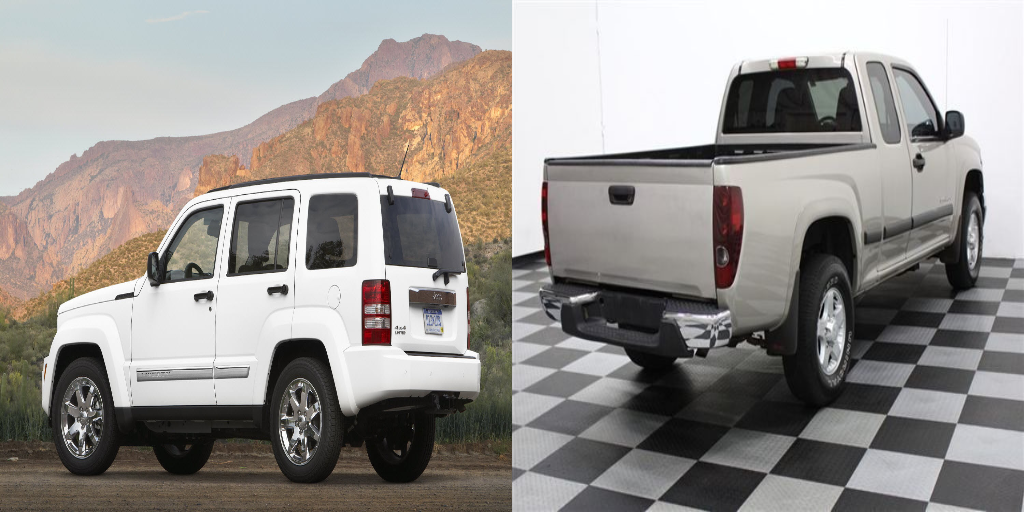

In [87]:
Image.fromarray(np.hstack((car_img, another_car_img)))

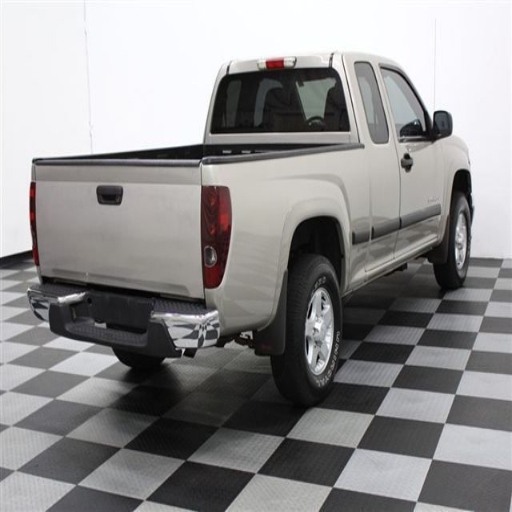

In [93]:
image, image_float, input_tensor = get_image_from_path("/content/drive/MyDrive/cars_train/00068.jpg")
Image.fromarray(image)

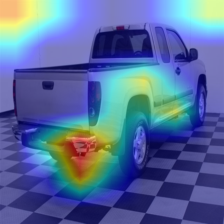

In [94]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features

    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

target_layers = [pl_model.model.features[-1]]

car_targets = [SimilarityToConceptTarget(car_concept_features)]

with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

Видно, что сеть смотрит выхлопную трубу и края картинки, что мешает распознаванию

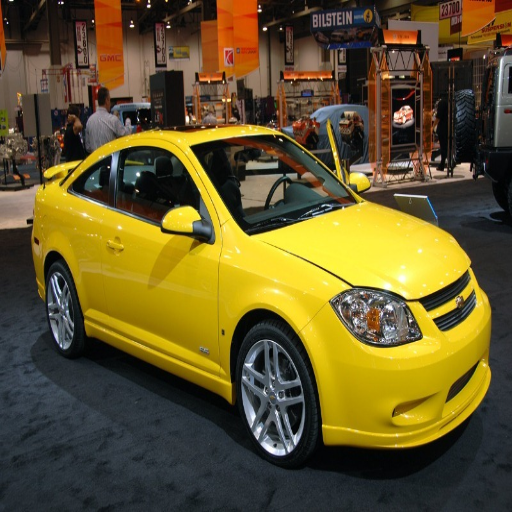

In [95]:
image, image_float, input_tensor = get_image_from_path("/content/drive/MyDrive/cars_train/00126.jpg")
Image.fromarray(image)

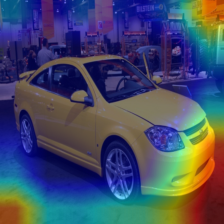

In [96]:
target_layers = [pl_model.model.features[-1]]

car_targets = [SimilarityToConceptTarget(car_concept_features)]

with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

Опять смотрит не на саму машину, а на края экрана, пол и объекты сбоку

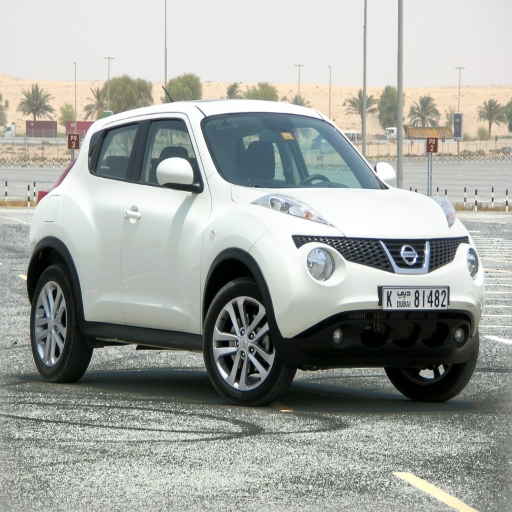

In [97]:
image, image_float, input_tensor = get_image_from_path("/content/drive/MyDrive/cars_train/00024.jpg")
Image.fromarray(image)

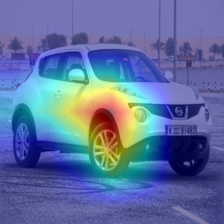

In [ ]:
target_layers = [pl_model.model.features[-1]]

car_targets = [SimilarityToConceptTarget(car_concept_features)]

with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

Тут уже на машину, но с акцентом на колесо. Мне кажется, что сеть просто не доучилась, так как мне не хватает мощностей на большее количество эпох